In [1]:
from utils import *
import pandas as pd 
import numpy as np
import warnings 
warnings.filterwarnings("ignore") 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn_crfsuite.metrics import flat_classification_report 
from sklearn.metrics import f1_score  
from keras.preprocessing.text import text_to_word_sequence 
import pickle as pkl
import seaborn as sns
import codecs
from tqdm import tqdm
from keras_contrib.layers import CRF 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
train_sent = pkl.load(open('DATA/training_instances.pkl', 'rb'))

In [3]:
train_sent[0]

[('Thousands', 'capitalized', 'O'),
 ('of', 'lowercase', 'O'),
 ('demonstrators', 'lowercase', 'O'),
 ('have', 'lowercase', 'O'),
 ('marched', 'lowercase', 'O'),
 ('through', 'lowercase', 'O'),
 ('London', 'capitalized', 'B-geo'),
 ('to', 'lowercase', 'O'),
 ('protest', 'lowercase', 'O'),
 ('the', 'lowercase', 'O'),
 ('war', 'lowercase', 'O'),
 ('in', 'lowercase', 'O'),
 ('Iraq', 'capitalized', 'B-geo'),
 ('and', 'lowercase', 'O'),
 ('demand', 'lowercase', 'O'),
 ('the', 'lowercase', 'O'),
 ('withdrawal', 'lowercase', 'O'),
 ('of', 'lowercase', 'O'),
 ('British', 'capitalized', 'B-gpe'),
 ('troops', 'lowercase', 'O'),
 ('from', 'lowercase', 'O'),
 ('that', 'lowercase', 'O'),
 ('country', 'lowercase', 'O'),
 ('.', 'punct', 'O')]

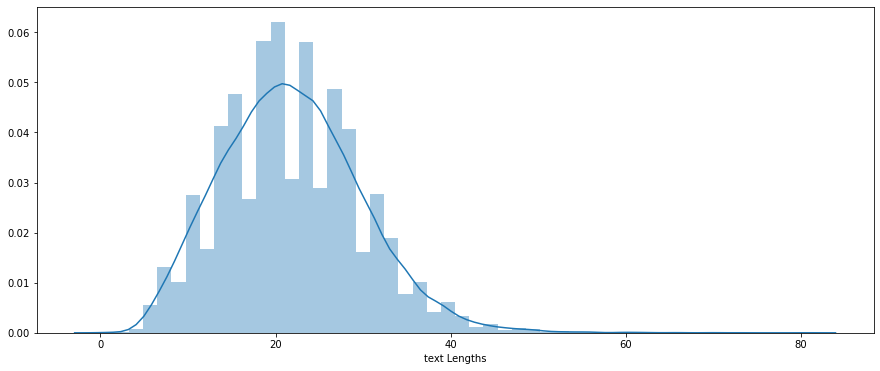

In [4]:
text_lengths=pd.Series([len(i) for i in train_sent],name="text Lengths")
fig,ax=plt.subplots(1,figsize=(15,6))
sns.distplot(text_lengths)
fig.show()


In [5]:
batch_size = 32
epochs = 6
max_len = 100
max_len_char = 10

In [6]:
embed_dim = 100
num_heads = 10
ff_dim = 64

In [7]:
words = set()

tags = set()
[words.add(j[0]) for i in train_sent for j in i]
words.add("PAD")

[tags.add(j[2]) for i in train_sent for j in i]
tags.add("PAD")
print(len(words), len(tags))
print(tags)

30172 17
{'I-gpe', 'I-art', 'B-gpe', 'I-per', 'B-art', 'I-eve', 'B-org', 'I-org', 'B-tim', 'I-tim', 'I-nat', 'I-geo', 'B-nat', 'B-per', 'B-geo', 'B-eve', 'O'}


In [8]:
words, tags = list(words), list(tags)

In [9]:
word_to_index = {w : i  for i, w in enumerate(words)}
tag_to_index = {w : i for i, w in enumerate(tags)}

In [10]:
X = [[word_to_index[w[0]] for w in s] for s in train_sent]
X = keras.preprocessing.sequence.pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [11]:
y = [[tag_to_index[w[2]] for w in s] for s in train_sent]
y = keras.preprocessing.sequence.pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [12]:
input = Input(shape = (max_len,))
model = Embedding(len(words), embed_dim,
          weights=[embedding_matrix], input_length=max_len, trainable=False)(input)
# model = Embedding(input_dim = len(words), output_dim = embedding, input_length = max_len)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)

model = Bidirectional(LSTM(units = 20, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(len(tags), activation="relu"))(model)

model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[])

model.summary()

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
token_and_position_embedding (None, 100, 100)          3027200   
_________________________________________________________________
transformer_block (Transform (None, 100, 100)          53764     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 18)           7920      
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 5)            95    

In [15]:
history = model.fit(X, np.array(y), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, 
                    callbacks=[checkpointer])

Epoch 1/6


AttributeError: in user code:

    /home/ashutosh/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/ashutosh/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ashutosh/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ashutosh/miniconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ashutosh/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:533 train_step  **
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/ashutosh/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/ashutosh/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /home/ashutosh/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:246 call
        return self.fn(y_true, y_pred, **self._fn_kwargs)
    /home/ashutosh/miniconda3/lib/python3.7/site-packages/keras_contrib/losses/crf_losses.py:54 crf_loss
        crf, idx = y_pred._keras_history[:2]

    AttributeError: 'Tensor' object has no attribute '_keras_history'


In [ ]:
history.history.keys()